In [1]:
library(forecast)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# library(doParallel)
library(doMC)
options(cores = 8)
registerDoMC()

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [3]:
df_eu  <-  read.csv(file="hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )

In [4]:
gdp_agg <- rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = 4, start = 2000) 

In [5]:
gdp_agg  <-  gdp_agg/1000
df_eu  <-  df_eu/1000

### Top Level: AR(3)

#### Sliding window

In [6]:
ac <- c()
l <- list()

In [17]:
for (i in 0:4){
    st_year  <-  2000 + i
    train_start  <- st_year
    train_end  <- st_year + 0.25*51
    test_start  <- st_year + 0.25*(51+1) 
    test_end  <-  st_year + 0.25*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        train <- window(gdp_agg, start=train_start, end=train_end)
    }
    
    if (i == 4){
        test <- window(gdp_agg, start=test_start)}
    else{
        test <- window(gdp_agg, start=test_start, end=test_end)
    }
        
    gdp_arima  <- forecast(Arima(train, order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE), h = 8  )
    l[[i+1]]  <-   gdp_arima
    ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    
    }

[1] 2000.00 2012.75 2013.00 2014.75
[1] 2001.00 2013.75 2014.00 2015.75
[1] 2002.00 2014.75 2015.00 2016.75
[1] 2003.00 2015.75 2016.00 2017.75
[1] 2004.00 2016.75 2017.00 2018.75


In [18]:
ac * 1000

[1] 30004.50 70819.46 65892.64 71879.66 62743.83 30004.50 70819.46 65892.64
 [9] 71879.66 62743.83 30004.50 70819.46 65892.64 71879.66 62743.83

In [19]:
mean(ac * 1000)

[1] 60268.02

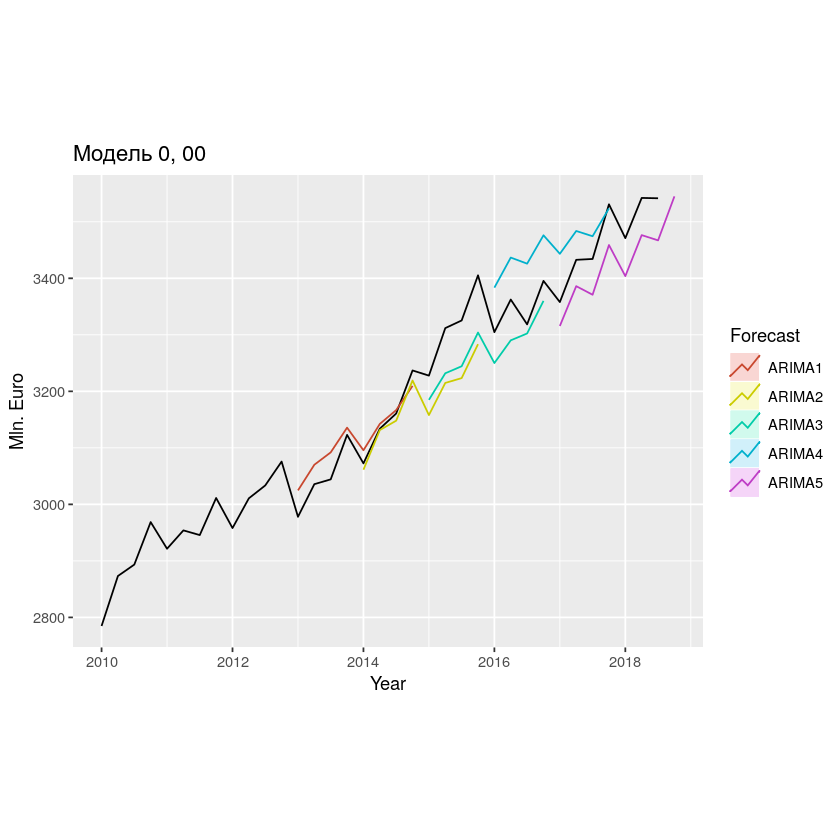

In [20]:
autoplot(window(gdp_agg, start=2010))+
    autolayer(l[[1]], series="ARIMA1", PI=FALSE) +
    autolayer(l[[2]], series="ARIMA2", PI=FALSE) +
    autolayer(l[[3]], series="ARIMA3", PI=FALSE) +
    autolayer(l[[4]], series="ARIMA4", PI=FALSE) +
    autolayer(l[[5]], series="ARIMA5", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)

#### Growing window

In [26]:
per  <-  4
# ac <- c()
m_top  <- l_test  <- l <- list()
df_ac_1  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [27]:
for (i in 0:per){
    st_year  <-  2000 + i
    train_start  <- st_year
    train_end  <- st_year + 0.25*51
    test_start  <- st_year + 0.25*(51+1) 
    test_end  <-  st_year + 0.25*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    train <- window(gdp_agg, end=train_end)
    
    if (i == 4){
        test <- window(gdp_agg, start=test_start)}
    else{
        test <- window(gdp_agg, start=test_start, end=test_end)
    }
    
    m_top[[i+1]]  <- Arima(train, order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE)
    
    l[[i+1]] <- forecast(m_top[[i+1]], h = 8  )
    l_test[[i+1]]  <-   test
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_1  <-  bind_rows(df_ac_1, accuracy(l[[i+1]], test)[2, c(2,5,7,8)]) 
    }

[1] 2000.00 2012.75 2013.00 2014.75
[1] 2001.00 2013.75 2014.00 2015.75
[1] 2002.00 2014.75 2015.00 2016.75
[1] 2003.00 2015.75 2016.00 2017.75
[1] 2004.00 2016.75 2017.00 2018.75


In [28]:
df_ac_1

RMSE,MAPE,ACF1,Theil's U
30.00450,0.8423452,0.3147106,0.4774273
70.35219,1.6318005,0.6839184,1.2522039
63.19442,1.7068541,0.2837959,0.9335619
71.40787,1.9332753,0.3711943,1.1356505
55.14303,1.5573230,0.4297768,0.9073770


In [29]:
colMeans(df_ac_1)

RMSE       MAPE       ACF1  Theil's U 
58.0204039  1.5343196  0.4166792  0.9412441

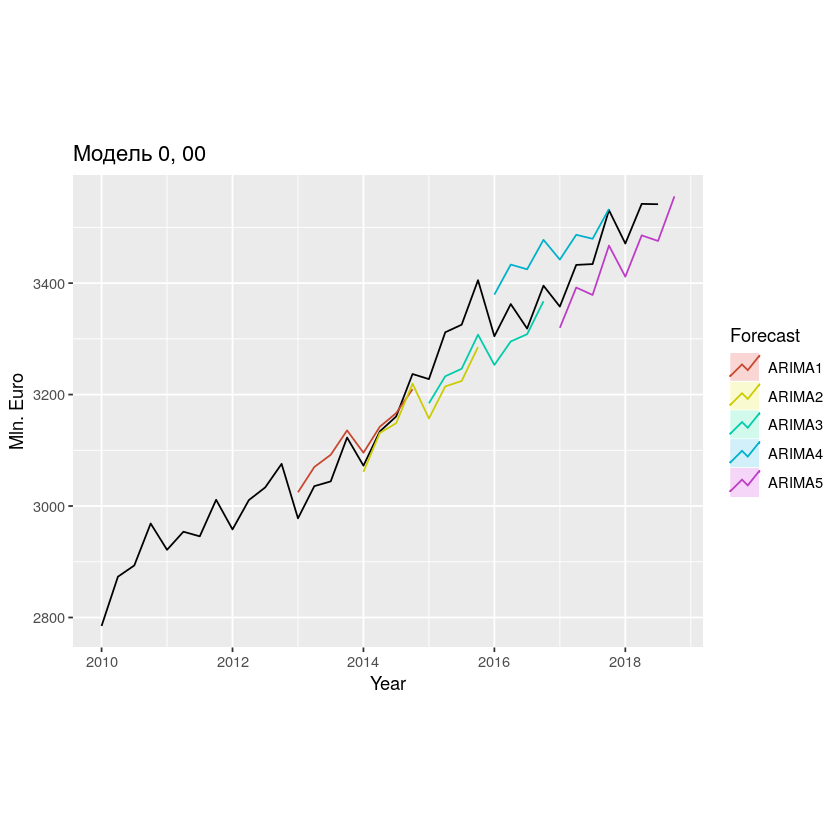

In [30]:
autoplot(window(gdp_agg, start=2010))+
    autolayer(l[[1]], series="ARIMA1", PI=FALSE) +
    autolayer(l[[2]], series="ARIMA2", PI=FALSE) +
    autolayer(l[[3]], series="ARIMA3", PI=FALSE) +
    autolayer(l[[4]], series="ARIMA4", PI=FALSE) +
    autolayer(l[[5]], series="ARIMA5", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)

### Top Level: AR(3) + structural break 

In [32]:
library(strucchange)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich


In [33]:
per  <-  4
bp <- c()
for (i in 0:per){
    st_year  <-  2000 + i
    train_start  <- st_year
    train_end  <- st_year + 0.25*51
    train <- window(gdp_agg, end=train_end)
    ## F statistics indicate one breakpoint
    fs.gdp_agg <- Fstats(train  ~  1 + time(train))
    bp  <-  c(bp, breakpoints(fs.gdp_agg)[[1]])    
    }

In [34]:
all(bp == 36)

[1] TRUE

In [35]:
dum  <-  rep(c(0,1), c(breakpoints(fs.gdp_agg)[[1]], length(gdp_agg) - breakpoints(fs.gdp_agg)[[1]]))

#### Growing window

In [36]:
per  <-  4
# ac <- c()
m_top  <- l_str <- list()
df_ac_1s  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [37]:
for (i in 0:per){
    st_year  <-  2000 + i
    train_start  <- st_year
    train_end  <- st_year + 0.25*51
    test_start  <- st_year + 0.25*(51+1) 
    test_end  <-  st_year + 0.25*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    train <- window(gdp_agg, end=train_end)
    
    if (i == 4){
        test <- window(gdp_agg, start=test_start)
        t_e  <-  length(dum)
        hh  <-  7}
    else{
        test <- window(gdp_agg, start=test_start, end=test_end)
        t_e  <-  ((test_end-2000)*4+1)
        hh  <-  8
    }
        
    m_top[[i+1]]  <- Arima(train, order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg=dum[1:((train_end-2000)*4+1)] )
    l_str[[i+1]] <- forecast(m_top[[i+1]], h = hh, xreg = dum[((test_start-2000)*4+1): t_e ]  )
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_1s  <-  bind_rows(df_ac_1s, accuracy(l_str[[i+1]], test)[2, c(2,5,7,8)]) 
    }

[1] 2000.00 2012.75 2013.00 2014.75


Warning message in forecast.Arima(m_top[[i + 1]], h = hh, xreg = dum[((test_start - :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”

[1] 2001.00 2013.75 2014.00 2015.75


Warning message in forecast.Arima(m_top[[i + 1]], h = hh, xreg = dum[((test_start - :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”

[1] 2002.00 2014.75 2015.00 2016.75


Warning message in forecast.Arima(m_top[[i + 1]], h = hh, xreg = dum[((test_start - :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”

[1] 2003.00 2015.75 2016.00 2017.75


Warning message in forecast.Arima(m_top[[i + 1]], h = hh, xreg = dum[((test_start - :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”

[1] 2004.00 2016.75 2017.00 2018.75


Warning message in forecast.Arima(m_top[[i + 1]], h = hh, xreg = dum[((test_start - :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”

In [38]:
df_ac_1s

RMSE,MAPE,ACF1,Theil's U
41.43026,1.220307,0.1147186,0.6791211
61.09521,1.376503,0.6855353,1.0880309
56.10122,1.456742,0.4673110,0.8172604
69.57626,1.926973,0.2951082,1.1195179
41.58108,1.182393,0.3127301,0.6762258


In [39]:
colMeans(df_ac_1s)

RMSE       MAPE       ACF1  Theil's U 
53.9568052  1.4325835  0.3750806  0.8760312

In [40]:
df_ac_1

RMSE,MAPE,ACF1,Theil's U
30.00450,0.8423452,0.3147106,0.4774273
70.35219,1.6318005,0.6839184,1.2522039
63.19442,1.7068541,0.2837959,0.9335619
71.40787,1.9332753,0.3711943,1.1356505
55.14303,1.5573230,0.4297768,0.9073770


In [8]:
colMeans(df_ac_1)

RMSE       MAPE       ACF1  Theil's U 
58.0204039  1.5343196  0.4166792  0.9412441

In [45]:
library(multDM)

In [50]:
dmt  <-  list()

for (i in 0:per){    
    dmt[[i+1]]  <-  DM.test(f1 = l_str[[i+1]]$mean, f2 = l[[i+1]]$mean,y = l_test[[i+1]],loss.type="SPE",c=TRUE,H1="more", h=2)
}

In [52]:
dmt

[[1]]

	Diebold-Mariano test

data:  l_str[[i + 1]]$mean and l[[i + 1]]$mean and l_test[[i + 1]]
statistic = 2.9064, forecast horizon = 2, p-value = 0.9886
alternative hypothesis: Forecast f1 is more accurate than f2.


[[2]]

	Diebold-Mariano test

data:  l_str[[i + 1]]$mean and l[[i + 1]]$mean and l_test[[i + 1]]
statistic = -1.6355, forecast horizon = 2, p-value = 0.07298
alternative hypothesis: Forecast f1 is more accurate than f2.


[[3]]

	Diebold-Mariano test

data:  l_str[[i + 1]]$mean and l[[i + 1]]$mean and l_test[[i + 1]]
statistic = -4.1164, forecast horizon = 2, p-value = 0.00224
alternative hypothesis: Forecast f1 is more accurate than f2.


[[4]]

	Diebold-Mariano test

data:  l_str[[i + 1]]$mean and l[[i + 1]]$mean and l_test[[i + 1]]
statistic = -0.77682, forecast horizon = 2, p-value = 0.2314
alternative hypothesis: Forecast f1 is more accurate than f2.


[[5]]

	Diebold-Mariano test

data:  l_str[[i + 1]]$mean and l[[i + 1]]$mean and l_test[[i + 1]]
statistic = -6.68

In [77]:
ts1 = ts(c(l_str[[1]]$mean, l_str[[3]]$mean, l_str[[5]]$mean), start=start(l_str[[1]]$mean), frequency=frequency(l_str[[1]]$mean))
ts2 = ts(c(l[[1]]$mean, l[[3]]$mean, l[[5]]$mean), start=start(l[[1]]$mean), frequency=frequency(l[[1]]$mean))
ts3 = ts(c(l_test[[1]], l_test[[3]], l_test[[5]]), start=start(l_test[[1]]), frequency=frequency(l_test[[1]]))
DM.test(f1 = ts1, f2 = ts2, y = ts3,loss.type="SPE",c=TRUE,H1="more", h=15)


	Diebold-Mariano test

data:  ts1 and ts2 and ts3
statistic = -4.2642, forecast horizon = 15, p-value = 0.0001582
alternative hypothesis: Forecast f1 is more accurate than f2.


In [59]:
dmt_s  <-  list()

for (i in 0:per){    
    dmt_s[[i+1]]  <-  DM.test(f1 = l_str[[i+1]]$mean, f2 = l[[i+1]]$mean,y = l_test[[i+1]],loss.type="SPE",c=TRUE,H1="same", h=2)
}

In [60]:
dmt_s

[[1]]

	Diebold-Mariano test

data:  l_str[[i + 1]]$mean and l[[i + 1]]$mean and l_test[[i + 1]]
statistic = 2.9064, forecast horizon = 2, p-value = 0.02278
alternative hypothesis: Forecast f1 and f2 have different accuracy.


[[2]]

	Diebold-Mariano test

data:  l_str[[i + 1]]$mean and l[[i + 1]]$mean and l_test[[i + 1]]
statistic = -1.6355, forecast horizon = 2, p-value = 0.146
alternative hypothesis: Forecast f1 and f2 have different accuracy.


[[3]]

	Diebold-Mariano test

data:  l_str[[i + 1]]$mean and l[[i + 1]]$mean and l_test[[i + 1]]
statistic = -4.1164, forecast horizon = 2, p-value = 0.00448
alternative hypothesis: Forecast f1 and f2 have different accuracy.


[[4]]

	Diebold-Mariano test

data:  l_str[[i + 1]]$mean and l[[i + 1]]$mean and l_test[[i + 1]]
statistic = -0.77682, forecast horizon = 2, p-value = 0.4627
alternative hypothesis: Forecast f1 and f2 have different accuracy.


[[5]]

	Diebold-Mariano test

data:  l_str[[i + 1]]$mean and l[[i + 1]]$mean and l_test[[i 

### Third Level: AR(3)

In [6]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [11]:
df_eu  <-  as.data.table(df_eu)

data  <-  df_eu

y  <-  hts(data, characters = c(2,1))
s  <-  smatrix(y)

gts_train  <- window(y, start=1, end=68)
gts_test  <- window(y, start=69, end=75)

allts <- aggts(gts_train)

allf <- matrix(, nrow=8, ncol=ncol(allts))

In [112]:
start_time <- Sys.time()
ms <-  foreach(i=1:ncol(allts)) %dopar% {
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method="ML")  # "non-stationary seasonal AR part from CSS"
    }
end_time <- Sys.time()
end_time - start_time

Time difference of 7.438541 secs

In [113]:
for(i in 1:ncol(allts)){
    allf[,i] <- forecast(ms[[i]], h=8)$mean
    }

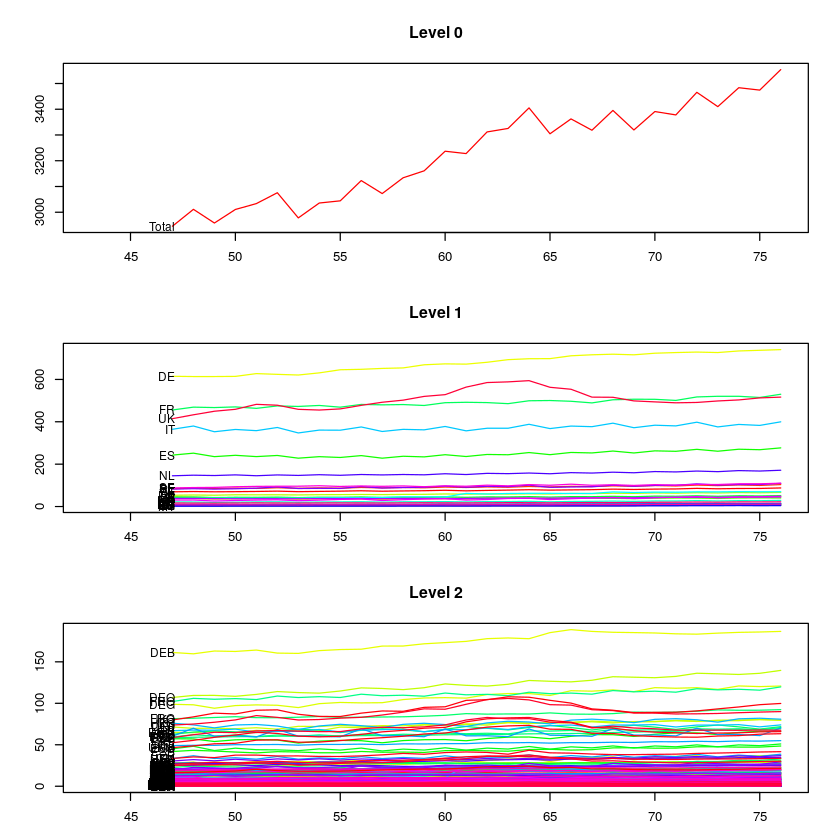

In [114]:
allf <- ts(allf)

colnames(allf)  <-  colnames(allts)  

# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)

forecasts_7 = y.f[[1]]

colnames(forecasts_7) = colnames(y[[1]])

data_f5 = rbind(gts_train[[1]], forecasts_7)

y_f5 = hts(data_f5, characters = c(2,1))

plot(y_f5, levels = c(0, 1, 2), include = 30)

In [115]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [116]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.479108,0.1372003,-0.4000582,-0.7640417,-1.139143,1.433761,20.993855,-0.6348199,-0.9860091,0.1764228,⋯,0.5254852,5.572486,3.114959,5.145498,1.288991,-2.532268,5.844225,5.526316,0.010812218,2.051676
RMSE,56.441659,0.6107677,0.5533579,0.8745297,1.228358,1.723067,22.798602,1.0909236,1.0712055,0.5696737,⋯,0.5975323,5.969466,3.133469,5.243553,1.491785,3.075701,5.959264,5.665983,3.432126675,2.165728
MAE,55.479108,0.4972694,0.4993664,0.7640417,1.139143,1.543990,20.993855,0.9261588,0.9860091,0.4326121,⋯,0.5469913,5.572486,3.114959,5.145498,1.288991,2.532268,5.844225,5.526316,2.650990825,2.051676
MAPE,1.593175,0.5872652,0.5043030,6.7438361,26.153118,3.404353,2.781255,1.4554473,18.5375276,1.0712226,⋯,15.8023019,7.487110,9.721560,5.502204,3.731008,6.966558,8.251004,8.339578,2.861844463,9.184606
MPE,1.593175,0.1538827,-0.4007889,-6.7438361,-26.153118,3.123778,2.781255,-0.9941663,-18.5375276,0.4178646,⋯,15.1259575,7.487110,9.721560,5.502204,3.731008,-6.966558,8.251004,8.339578,0.002395284,9.184606


In [117]:
accuracy.gts(gts_forecasts_7, gts_test)[,1]

ME      RMSE       MAE      MAPE       MPE 
55.479108 56.441659 55.479108  1.593175  1.593175

#### CV AR(3) Third Level 

In [164]:
df_eu = as.data.table(df_eu)
data  <-  df_eu
y = hts(data, characters = c(2,1))
s = smatrix(y)

In [165]:
per  <-  4
# ac <- c()
m_top  <- l_top <- list()
df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [166]:
for (i in 0:per){
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51
    test_start  <- st_year + 1*(51+1) 
    test_end  <-  st_year + 1*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    gts_train <- window(y, end=train_end)
    
    if (i == 4){
        gts_test <- window(y, start=test_start)
        hh = 7
    }
    else{
        gts_test <- window(y, start=test_start, end=test_end)
        hh = 8
    }
    
    allts <- aggts(gts_train)
    
#     if (i == 1){
#         met = "CSS"}
#     else{
#         met = "ML" 
#     }
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }
        
    allf <- matrix(, nrow=hh, ncol=ncol(allts))

    for(j in 1:ncol(allts)){
        allf[,j] <- forecast(ms[[j]], h=hh)$mean
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = c(2,1))
    
    
    if (i == 4){
        gts_forecasts_7 <- window(y_f5, start=test_start)}
    else{
        gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
    }
        
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac  <-  bind_rows(df_ac, accuracy.gts(gts_forecasts_7, gts_test)[, 1]) 
    }

[1]  1 52 53 60
[1]  5 56 57 64
[1]  9 60 61 68
[1] 13 64 65 72
[1] 17 68 69 76


__ met  <-  "CSS"__

In [113]:
df_ac 

ME,RMSE,MAE,MAPE,MPE
29.19700,53.44973,44.17503,1.406911,0.9084537
68.73230,87.43198,68.73230,2.078017,2.0780171
67.39017,71.83022,67.39017,2.018860,2.0188603
-70.66928,76.20563,70.66928,2.098900,-2.0989004
62.77367,64.49063,62.77367,1.801197,1.8011968


__ met  <-  "ML"__

In [167]:
df_ac

ME,RMSE,MAE,MAPE,MPE
-17.87512,29.72522,25.16467,0.8207038,-0.5955032
55.09397,71.33892,55.09397,1.6645230,1.6645230
57.56785,63.64543,57.56785,1.7249067,1.7249067
-63.67907,70.28057,63.67907,1.8938485,-1.8938485
55.47911,56.44166,55.47911,1.5931747,1.5931747


In [168]:
colMeans(df_ac)

ME       RMSE        MAE       MAPE        MPE 
17.3173480 58.2863592 51.3969354  1.5394313  0.4986505

#### AR(3) for Top level

In [132]:
df_ac_1

RMSE,MAPE,ACF1,Theil's U
30.00450,0.8423452,0.3147106,0.4774273
70.35219,1.6318005,0.6839184,1.2522039
63.19442,1.7068541,0.2837959,0.9335619
71.40787,1.9332753,0.3711943,1.1356505
55.14303,1.5573230,0.4297768,0.9073770


In [129]:
colMeans(df_ac_1)

RMSE       MAPE       ACF1  Theil's U 
58.0204039  1.5343196  0.4166792  0.9412441

### Third Level: AR(3) + structural break (2008)

In [124]:
dum

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [169]:
df_eu  <- as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = c(2,1))
s  <-  smatrix(y)

In [170]:
per  <-  4
# ac <- c()
m_top  <- l_top <- list()
df_ac_s  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [ ]:
for (i in 0:per){
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51
    test_start  <- st_year + 1*(51+1) 
    test_end  <-  st_year + 1*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    gts_train <- window(y, end=train_end)
    
    if (i == 4){
        gts_test <- window(y, start=test_start)
        t_e  <-  length(dum)
        hh  <-  7
    }
    else{
        gts_test <- window(y, start=test_start, end=test_end)
        t_e  <-  test_end
        hh  <-  8 
    }
    
    allts <- aggts(gts_train)
    
#     if (i == 1){
#         met = "CSS"}
#     else{
#         met = "ML" 
#     }
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method="ML", xreg=dum[1:train_end]), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method="CSS", xreg=dum[1:train_end])
#             error = function(e) NULL
        )
    }
    
    
    allf <- matrix(, nrow=hh, ncol=ncol(allts))

    for(j in 1:ncol(allts)){
        allf[,j] <- forecast(ms[[j]], h=hh, xreg = dum[test_start:t_e])$mean
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = c(2,1))
    
    
    if (i == 4){
        gts_forecasts_7 <- window(y_f5, start=test_start)}
    else{
        gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
    }
        
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_s  <-  bind_rows(df_ac_s, accuracy.gts(gts_forecasts_7, gts_test)[, 1]) 
    }

In [143]:
length(allts[,i])
length(dum[1:train_end])
length(dum[test_start:t_e])

[1] 52

[1] 52

[1] 8

In [134]:
ms[lengths(ms) == 0]

[[1]]
NULL

[[2]]
NULL

In [135]:
which(sapply(ms, is.null))

[1]  50 223

In [172]:
df_ac_s

ME,RMSE,MAE,MAPE,MPE
-35.58530,40.18503,36.33378,1.186612,-1.163489
46.79878,62.21546,46.79878,1.412525,1.412525
46.99553,56.54978,48.95910,1.469497,1.410326
-64.21756,68.95491,64.21756,1.906320,-1.906320
42.14006,42.59684,42.14006,1.211301,1.211301


In [173]:
colMeans(df_ac_s)

ME       RMSE        MAE       MAPE        MPE 
 7.2263016 54.1004052 47.6898590  1.4372512  0.1928688

__ Top Level: AR(3) + structural break__

In [150]:
colMeans(df_ac_1s)

RMSE       MAPE       ACF1  Theil's U 
53.9568052  1.4325835  0.3750806  0.8760312

__ Third Level: AR(3) __

In [66]:
colMeans(df_ac)

ME       RMSE        MAE       MAPE        MPE 
17.3173480 58.2863592 51.3969354  1.5394313  0.4986505

__ Top Level: AR(3) __

In [8]:
colMeans(df_ac_1)

RMSE       MAPE       ACF1  Theil's U 
58.0204039  1.5343196  0.4166792  0.9412441

### Third Level: AR(3) + structural break 

In [192]:
per  <-  4
l_bp  <- list()

for (i in 0:per){
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51

    gts_train <- window(y, end=train_end)   
    allts <- aggts(gts_train)
    
    fs.gdp_agg <-  foreach(j=1:ncol(allts)) %dopar% {
        tra  <-  msts(allts[,j], seasonal.periods = 4)
        model  <- Fstats(tra  ~  1 + time(tra))
        }
    bp <- c()
    ## F statistics indicate one breakpoint
    for (j in 1:ncol(allts)){
        bp  <-  c(bp, breakpoints(fs.gdp_agg[[j]])[[1]]) 
        }
    l_bp[[i+1]] <- bp
    }

In [193]:
l_bp  <- data.frame(matrix(unlist(l_bp), nrow=(per+1), byrow=T))

In [208]:
df_eu  <- as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = c(2,1))
s  <-  smatrix(y)

In [209]:
per  <-  4
# ac <- c()
m_top  <- l_top <- list()
df_ac_sa  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [210]:
for (i in 0:per){
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51
    test_start  <- st_year + 1*(51+1) 
    test_end  <-  st_year + 1*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    gts_train <- window(y, end=train_end)
    
    if (i == 4){
        gts_test <- window(y, start=test_start)
        t_e  <-  length(dum)
        hh  <-  7
    }
    else{
        gts_test <- window(y, start=test_start, end=test_end)
        t_e  <-  test_end
        hh  <-  8 
    }
    
    allts <- aggts(gts_train)
        
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        dum_auto  <-  rep(c(0,1), c(l_bp[(i+1),j], length(gdp_agg) - l_bp[(i+1),j]))
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method="ML", xreg=dum_auto[1:train_end]), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method="CSS", xreg=dum[1:train_end])
#             error = function(e) NULL
        )
    }
    
    
    allf <- matrix(, nrow=hh, ncol=ncol(allts))

    for(j in 1:ncol(allts)){
        dum_auto  <-  rep(c(0,1), c(l_bp[(i+1),j], length(gdp_agg) - l_bp[(i+1),j]))
        allf[,j] <- forecast(ms[[j]], h=hh, xreg = dum_auto[test_start:t_e])$mean
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = c(2,1))
    
    
    if (i == 4){
        gts_forecasts_7 <- window(y_f5, start=test_start)}
    else{
        gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
    }
        
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_sa  <-  bind_rows(df_ac_sa, accuracy.gts(gts_forecasts_7, gts_test)[, 1]) 
    }

[1]  1 52 53 60


Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. P

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

[1]  5 56 57 64


Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. P

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

[1]  9 60 61 68


Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. P

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

[1] 13 64 65 72


Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. P

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

[1] 17 68 69 76


Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. P

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j]], h = hh, xreg = dum_auto[test_start:t_e]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Ar

In [214]:
df_ac_sa

ME,RMSE,MAE,MAPE,MPE
-35.56694,40.18198,36.34471,1.186941,-1.162913
46.85718,62.25154,46.85718,1.414317,1.414317
47.03895,56.55225,48.96649,1.469709,1.411624
-64.05012,68.81104,64.05012,1.901414,-1.901414
42.29784,42.76788,42.29784,1.215777,1.215777


In [215]:
colMeans(df_ac_sa)

ME       RMSE        MAE       MAPE        MPE 
 7.3153846 54.1129379 47.7032685  1.4376316  0.1954782

__Third Level: AR(3) + structural break (2008)__

In [147]:
df_ac_s

ME,RMSE,MAE,MAPE,MPE
-35.58530,40.18503,36.33378,1.186612,-1.163489
46.79878,62.21546,46.79878,1.412525,1.412525
46.99553,56.54978,48.95910,1.469497,1.410326
-64.21756,68.95491,64.21756,1.906320,-1.906320
42.14006,42.59684,42.14006,1.211301,1.211301


In [149]:
colMeans(df_ac_s)

ME       RMSE        MAE       MAPE        MPE 
 7.2263016 54.1004052 47.6898590  1.4372512  0.1928688

### AR(3)LI with neighbors (different metrics)


In [7]:
library(dtw)
library(TSclust)

Loading required package: proxy

Attaching package: ‘proxy’

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loaded dtw v1.20-1. See ?dtw for help, citation("dtw") for use in publication.

Loading required package: wmtsa
Loading required package: pdc
Loading required package: cluster


- "ACF" Autocorrelation-based method. See diss.ACF.

- "AR.LPC.CEPS" Linear Predictive Coding ARIMA method. This method has two value-per-series arguments, the ARIMA order, and the seasonality.See diss.AR.LPC.CEPS.

- "AR.MAH" Model-based ARMA method. See diss.AR.MAH.

- "AR.PIC" Model-based ARMA method. This method has a value-per-series argument, the ARIMA order. See diss.AR.PIC.

- "CDM" Compression-based dissimilarity method. See diss.CDM.

- "CID" Complexity-Invariant distance. See diss.CID.

- "COR" Correlation-based method. See diss.COR.

- "CORT" Temporal Correlation and Raw values method. See diss.CORT.

- "DTWARP" Dynamic Time Warping method. See diss.DTWARP.

- "DWT" Discrete wavelet transform method. See diss.DWT.

- "EUCL" Euclidean distance. See diss.EUCL. For many more convetional distances, see link[stats]{dist}, though you may need to transpose the dataset.

- "FRECHET" Frechet distance. See diss.FRECHET.

- "INT.PER" Integrate Periodogram-based method. See diss.INT.PER.

- "NCD" Normalized Compression Distance. See diss.NCD.

- "PACF" Partial Autocorrelation-based method. See diss.PACF.

- "PDC" Permutation distribution divergence. Uses the pdc package. See pdcDist for additional arguments and details. Note that series given by numeric matrices are interpreted row-wise and not column-wise, opposite as in pdcDist.

- "PER" Periodogram-based method. See diss.PER.

- "PRED" Prediction Density-based method. This method has two value-per-series agument, the logarithm and difference transform. See diss.PRED.

- "MINDIST.SAX" Distance that lower bounds the Euclidean, based on the Symbolic Aggregate approXimation measure. See diss.MINDIST.SAX.

- "SPEC.LLR" Spectral Density by Local-Linear Estimation method. See diss.SPEC.LLR.

- "SPEC.GLK" Log-Spectra Generalized Likelihood Ratio test method. See diss.SPEC.GLK.

- "SPEC.ISD" Intregated Squared Differences between Log-Spectras method. See diss.SPEC.ISD.

#### DTWARP 

In [9]:
df_eu  <- as.data.table(df_eu)

In [12]:
train  <- df_eu[1:68, ]

In [13]:
corr_mat <- diss(train, "DTWARP")

In [14]:
diss_mat_dtw  <- matrix(0, nrow = dim(train)[2], ncol = dim(train)[2])
i <- j  <- a  <- 1
while (i < dim(train)[2]){
  for (j in (i+1):dim(train)[2]){ 
    # cat("(", j, i, ")")
    diss_mat_dtw[j,i] <-  corr_mat[a]
    a <- a+1
    }
  i <-i+1
  }
diss_mat_dtw  <- diss_mat_dtw + t(diss_mat_dtw)
diag(diss_mat_dtw) <- NA

In [15]:
closests_dtw <- c()
for (i in 1:dim(df_eu)[2]){
    closests_dtw  <-  c(closests_dtw, which.min(diss_mat_dtw[i,]) )
}

In [16]:
names_dtw <- c()
for (i in closests_dtw){
    names_dtw  <-  c(names_dtw, colnames(train)[i])
}

In [36]:
iii  <- 130


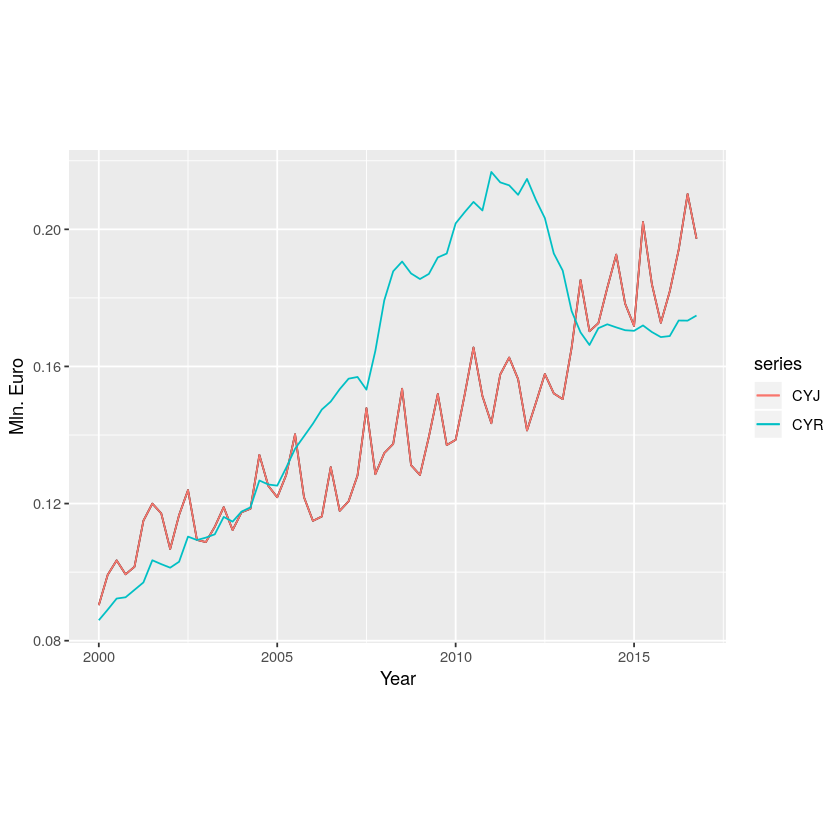

In [37]:
autoplot(ts(train[[names_dtw[iii]]], frequency = 4, start = 2000)) +
    autolayer(ts(train[[names_dtw[iii]]], frequency = 4, start = 2000), series=names_dtw[iii]) +
    autolayer(ts(train[[iii]], frequency = 4, start = 2000), series=colnames(train)[iii]) +
    xlab("Year") + ylab("Mln. Euro") +
    theme(aspect.ratio = 0.75)

#### 1 LAG

In [51]:
y  <-  hts(df_eu, characters = c(2,1))
gts_train  <- window(y, start=1, end=68)
gts_test  <- window(y, start=69, end=75)

In [42]:
names_dtw_1  <-  c(rep(NA, 29), names_dtw)
allts <- aggts(gts_train)
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [44]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])])
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
    
#     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 4.958337 secs

In [45]:
gts_xreg  <- window(y, start=68, end=74)

In [46]:
gts_xreg[[1]]

ATA,ATB,ATF,ATG,ATJ,ATK,ATL,ATM,ATO,ATR,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
0.89065,18.27845,5.63635,18.56585,2.99815,3.18970,7.9045,8.30670,14.12205,2.23740,⋯,3.32365,72.45420,30.70315,91.19245,33.57805,38.16105,70.08445,63.60060,91.62565,20.92385
1.03250,18.01520,4.39055,18.90695,2.88050,3.25800,7.9679,7.46585,14.27320,2.24490,⋯,3.59320,74.97645,32.24720,92.44670,33.02210,37.84545,71.59135,64.38920,93.52510,22.22850
1.20875,18.06245,5.21615,18.47410,2.84580,3.31065,8.0615,7.91560,14.33190,2.28215,⋯,3.61505,72.49050,32.12795,93.37780,33.48840,38.39070,71.64390,65.20465,92.61890,22.95500
1.12585,18.05240,5.51870,18.96435,2.86735,3.32830,8.1856,8.18955,14.35740,2.28630,⋯,3.29030,69.75630,31.17990,90.96840,32.46695,35.16020,68.96380,63.84680,89.37170,22.18445
1.09515,18.55240,5.88915,19.30215,3.13615,3.41165,8.3175,8.69640,14.54885,2.28910,⋯,3.37820,74.50155,31.97810,92.24005,35.13315,36.63770,70.41395,66.32350,91.69625,22.15745
1.14710,18.83185,4.64855,19.75920,2.99555,3.48065,8.4335,8.10390,14.86715,2.30595,⋯,3.46795,76.03610,32.18300,92.37635,34.53595,37.06770,71.37610,66.69515,93.15065,21.99530
1.26070,19.01210,5.51185,19.30920,2.94800,3.28410,8.5505,8.36850,14.86670,2.33680,⋯,3.45315,74.99030,32.31600,95.32680,34.63635,38.04385,71.17480,67.98700,92.59380,22.36290


In [47]:
for(i in 30:ncol(allts)){
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=gts_xreg[[1]][,names_dtw_1[i]])$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains d

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

In [48]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [49]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [52]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.480214,0.1046802,-0.4211483,-0.7707137,-1.139857,1.421984,20.807402,-0.6353657,-0.9861409,0.1849814,⋯,0.3788707,6.789518,3.412702,6.001852,1.038541,-2.679072,5.196218,5.551909,-2.623824,3.643262
RMSE,56.441847,0.5880122,0.5720380,0.8808988,1.228387,1.712747,22.593553,1.0865905,1.0707298,0.5750572,⋯,0.4530576,7.099348,3.430590,6.073514,1.354676,3.151651,5.323384,5.697775,4.923092,3.690061
MAE,55.480214,0.4783750,0.5166008,0.7707137,1.139857,1.535223,20.807402,0.9232025,0.9861409,0.4297696,⋯,0.3913362,6.789518,3.412702,6.001852,1.117167,2.679072,5.196218,5.551909,4.160497,3.643262
MAPE,1.593208,0.5654438,0.5215677,6.8032252,26.172016,3.385652,2.756564,1.4507887,18.5427884,1.0630806,⋯,11.3182145,9.140374,10.650567,6.428707,3.227373,7.354955,7.334813,8.375757,4.511959,16.353309
MPE,1.593208,0.1157180,-0.4220727,-6.8032252,-26.172016,3.097415,2.756564,-0.9950527,-18.5427884,0.4389609,⋯,10.9261865,9.140374,10.650567,6.428707,2.985199,-7.354955,7.334813,8.375757,-2.865909,16.353309


#### 4 LAG

In [53]:
names_dtw_1  <-  c(rep(NA, 29), names_dtw)
allts <- aggts(gts_train)
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [54]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],4)
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
#     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 4.55094 secs

In [55]:
gts_xreg  <- window(y, start=(69-4), end=(75-4))

In [56]:
for(i in 30:ncol(allts)){
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=gts_xreg[[1]][,names_dtw_1[i]])$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains d

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

In [57]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [58]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [59]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.482903,0.1253195,-0.4480321,-0.7706936,-1.142105,1.440447,20.720097,-0.6368464,-0.9911654,0.1849266,⋯,0.4052557,6.290789,2.941291,3.974313,1.332441,-2.500453,5.052676,4.894236,3.075501,1.166185
RMSE,56.445739,0.5995348,0.5956698,0.8821821,1.232538,1.732213,22.516315,1.0948750,1.0776433,0.5789924,⋯,0.4625988,6.507554,2.966797,4.070372,1.541675,3.058035,5.194483,5.078580,3.778596,1.605482
MAE,55.482903,0.4901261,0.5389224,0.7706936,1.142105,1.551475,20.720097,0.9278706,0.9911654,0.4370254,⋯,0.4052557,6.290789,2.941291,3.974313,1.332441,2.589668,5.052676,4.894236,3.517602,1.381213
MAPE,1.593282,0.5789940,0.5440681,6.8011068,26.220146,3.420849,2.744882,1.4581498,18.6327621,1.0817840,⋯,11.6956370,8.479999,9.176524,4.250302,3.855483,7.111305,7.130207,7.380776,3.807719,6.171899
MPE,1.593282,0.1399250,-0.4493285,-6.8011068,-26.220146,3.138243,2.744882,-0.9973669,-18.6327621,0.4389959,⋯,11.6956370,8.479999,9.176524,4.250302,3.855483,-6.875570,7.130207,7.380776,3.328165,5.193948


#### 1, 4 LAGS

In [60]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [61]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])])
    reg4  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],4)
     
    
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg4), method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg4), method = "CSS"))
#
    
    #     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 5.123973 secs

In [62]:
gts_xreg1  <- window(y, start=(69-1), end=(75-1))
gts_xreg4  <- window(y, start=(69-4), end=(75-4))

In [63]:
for(i in 30:ncol(allts)){
    reg1f  <-  ts(gts_xreg1[[1]][,names_dtw_1[i]], start=2017)
    reg4f  <-  ts(gts_xreg4[[1]][,names_dtw_1[i]], start=2017)
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=cbind(reg1f,reg4f))$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

In [64]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [65]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [66]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.486064,0.08287046,-0.4649965,-0.7769826,-1.145910,1.425958,20.674048,-0.6404713,-0.9935146,0.2010327,⋯,0.1278774,6.501991,3.28807,5.625812,0.4199786,-2.780067,4.244106,7.087615,-0.1605809,2.553658
RMSE,56.447632,0.57685470,0.6109858,0.8884864,1.235404,1.721445,22.457056,1.0900697,1.0790863,0.5879855,⋯,0.3274235,6.690432,3.32535,5.713104,0.8738652,3.291062,4.391075,7.329319,3.4334913,2.661185
MAE,55.486064,0.46823674,0.5517800,0.7769826,1.145910,1.543008,20.674048,0.9246797,0.9935146,0.4327442,⋯,0.2842703,6.501991,3.28807,5.625812,0.7279976,2.788036,4.244106,7.087615,2.4935911,2.553658
MAPE,1.593376,0.55384377,0.5568972,6.8589272,26.312212,3.403163,2.738835,1.4531355,18.6822879,1.0695793,⋯,8.2993709,8.770482,10.26136,6.025961,2.1268102,7.646427,5.988837,10.678485,2.6971759,11.442702
MPE,1.593376,0.09002708,-0.4664384,-6.8589272,-26.312212,3.105226,2.738835,-1.0031442,-18.6822879,0.4787015,⋯,3.6600696,8.770482,10.26136,6.025961,1.1797288,-7.625371,5.988837,10.678485,-0.1951914,11.442702


#### 1:4 LAGS

In [67]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [68]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])])
    reg2  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],2)
    reg3  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],3)
    reg4  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],4)
    
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg2,reg3,reg4), method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg2,reg3,reg4), method = "CSS"))
#
    
    #     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 6.92964 secs

In [69]:
gts_xreg1  <- window(y, start=(69-1), end=(75-1))
gts_xreg2  <- window(y, start=(69-2), end=(75-2))
gts_xreg3  <- window(y, start=(69-3), end=(75-3))
gts_xreg4  <- window(y, start=(69-4), end=(75-4))

In [70]:
for(i in 30:ncol(allts)){
    reg1f  <-  ts(gts_xreg1[[1]][,names_dtw_1[i]], start=2017)
    reg2f  <-  ts(gts_xreg2[[1]][,names_dtw_1[i]], start=2017)
    reg3f  <-  ts(gts_xreg3[[1]][,names_dtw_1[i]], start=2017)
    reg4f  <-  ts(gts_xreg4[[1]][,names_dtw_1[i]], start=2017)
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=cbind(reg1f,reg2f,reg3f,reg4f))$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

In [71]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [72]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [73]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.500524,0.07888278,-0.4203932,-0.7909548,-1.160062,1.509309,20.695417,-0.6737407,-1.003724,0.1706709,⋯,0.3001420,5.653880,2.702531,6.743942,0.5718158,-2.786561,2.764934,8.931773,-1.124301,2.942303
RMSE,56.460689,0.58313293,0.5594219,0.8998568,1.247078,1.810727,22.477267,1.1230986,1.086680,0.5791826,⋯,0.4058244,5.770364,2.720476,6.862747,1.2348612,3.391762,3.146895,9.263480,3.544937,2.995448
MAE,55.500524,0.47962211,0.5049071,0.7909548,1.160062,1.619511,20.695417,0.9547047,1.003724,0.4387001,⋯,0.3154992,5.653880,2.702531,6.743942,1.0242195,2.931508,2.825359,8.931773,2.744222,2.942303
MAPE,1.593795,0.56751469,0.5097455,6.9801704,26.641957,3.569419,2.741668,1.5001025,18.881973,1.0850418,⋯,9.4350222,7.643013,8.437303,7.217725,2.9924858,8.038120,3.982200,13.453966,2.974706,13.204716
MPE,1.593795,0.08504006,-0.4216524,-6.9801704,-26.641957,3.288914,2.741668,-1.0552482,-18.881973,0.4022290,⋯,8.9902933,7.643013,8.437303,7.217725,1.5992241,-7.655123,3.895944,13.453966,-1.240501,13.204716


#### DTWARP CV

In [9]:
df_eu  <- as.data.table(df_eu)

In [10]:
per  <-  4

cm  <- foreach(i=0:per) %dopar% {
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51

    train  <- df_eu[1:train_end, ]
    corr_mat <- diss(train, "DTWARP")
    }
        

In [11]:
cm[[1]][1]

[1] 1306.955

In [14]:
num_dtw  <-  nam_dtw <- list()

for (k in 0:per){
    st_year  <-  1 + 4*k
    train_start  <- st_year
    train_end  <- st_year + 1*51
    train  <- df_eu[1:train_end, ]
    diss_mat_dtw  <- matrix(0, nrow = dim(train)[2], ncol = dim(train)[2])
    i <- j  <- a  <- 1
    while (i < dim(train)[2]){
      for (j in (i+1):dim(train)[2]){ 
        # cat("(", j, i, ")")
        diss_mat_dtw[j,i] <-  cm[[k+1]][a]
        a <- a+1
        }
      i <-i+1
      }
    diss_mat_dtw  <- diss_mat_dtw + t(diss_mat_dtw)
    diag(diss_mat_dtw) <- NA
    
    closests_dtw <- c()
    for (i in 1:dim(df_eu)[2]){
        closests_dtw  <-  c(closests_dtw, which.min(diss_mat_dtw[i,]) )
    }
    names_dtw <- c()
    for (i in closests_dtw){
        names_dtw  <-  c(names_dtw, colnames(train)[i])
    }
    
    num_dtw[[k+1]] <- closests_dtw
    nam_dtw[[k+1]] <- names_dtw
    
    }

In [15]:
num_dtw  <- data.frame(matrix(unlist(num_dtw), nrow=(per+1), byrow=T))
nam_dtw  <- data.frame(matrix(unlist(nam_dtw), nrow=(per+1), byrow=T))

In [16]:
table(num_dtw[,7])


185 212 254 
  2   1   2 

In [17]:
dddd  <-  t(data.frame(sapply(num_dtw, function(x) sort(table(x),  decreasing = TRUE)[1]) ))
dddd  <-  rbind(dddd, as.numeric(gsub("^.*\\.","",colnames(dddd))))                              
dddd  <-  rbind(dddd, sapply(num_dtw[2,], function(x) colnames(train)[x]))   
rownames(dddd)  <- NULL                             

In [18]:
dddd

X1.152,X2.192,X3.257,X4.194,X5.190,X6.37,X7.185,X8.22,X9.269,X10.200,⋯,X271.196,X272.92,X273.275,X274.279,X275.273,X276.118,X277.92,X278.98,X279.94,X280.96
5,5,3,5,5,5,2,3,5,5,⋯,3,5,5,5,5,4,3,3,3,5
152,192,257,194,190,37,185,22,269,200,⋯,196,92,275,279,273,118,92,98,94,96
LUB,ATB,FIL,ATG,NLR,DKL,FIG,ESJ,SEO,ATR,⋯,NLA,FRB,UKJ,UKO,UKF,ITM,FRB,ESG,FRG,FRK


In [19]:
nam_dtw

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280
LUB,ATB,FIL,ATG,NLR,DKL,FIG,ESJ,SEO,ATR,⋯,NLA,FRB,UKJ,UKO,UKF,ITM,FRB,ESG,FRG,FRK
LUB,ATB,FIL,ATG,NLR,DKL,FIG,ESJ,SEO,ATR,⋯,NLA,FRB,UKJ,UKO,UKF,ITM,FRB,ESG,FRG,FRK
LUB,ATB,FIL,ATG,NLR,DKL,NLJ,CZB,SEO,ATR,⋯,ATK,FRB,UKJ,UKO,UKF,ITM,FRB,FRM,FRG,FRK
LUB,ATB,DKM,ATG,NLR,DKL,NLJ,CZB,SEO,ATR,⋯,ATK,FRB,UKJ,UKO,UKF,ESO,FRG,FRM,UKG,FRK
LUB,ATB,PLL,ATG,NLR,DKL,PTB,CZB,SEO,ATR,⋯,ATK,FRB,UKJ,UKO,UKF,ITM,DEM,FRM,UKG,FRK


#### 1 LAG (auto)

In [129]:
df_eu  <- as.data.table(df_eu)
y  <-  hts(df_eu, characters = c(2,1))
s  <-  smatrix(y)

In [130]:
per  <-  4
# ac <- c()
m_top  <- l_top <- list()
df_ac_sa  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [119]:
i  <-  1
j <- 40
# lag(allts[,nam_dtw[(i+1),(j-29)]][1:length(allts[,nam_dtw[(i+1),(j-29)]])])
gts_xreg[[1]][,nam_dtw[(i+1),(j-29)] ]

Time Series:
Start = 64 
End = 71 
Frequency = 1 
[1] 0.88455 0.95390 1.13995 0.97825 0.89065 1.03250 1.20875 1.12585

In [132]:
for (i in 1:per){ # Not enough data to fit the model
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51
    test_start  <- st_year + 1*(51+1) 
    test_end  <-  st_year + 1*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    gts_train <- window(y, end=train_end)
    
    if (i == 4){
        gts_test <- window(y, start=test_start)
        t_e  <-  dim(y[[1]])[1]
        hh  <-  7
    }
    else{
        gts_test <- window(y, start=test_start, end=test_end)
        t_e  <-  test_end
        hh  <-  8 
    }
    
    allts <- aggts(gts_train)
    allf <- matrix(, nrow=hh, ncol=ncol(allts))

    
    for(j in 1:29){
        model  <- tryCatch(        
            Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML"), 
                error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "CSS"))
        allf[,j] <- forecast(model, h=hh)$mean
    }

        
    ms <-  foreach(j=30:ncol(allts)) %dopar% {
        reg1  <-  lag(allts[,nam_dtw[(i+1),(j-29)]][1:length(allts[,nam_dtw[(i+1),(j-29)]])])
        tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
    }
    
    

    gts_xreg  <- window(y, start=(test_start-1), end=(t_e-1))        
    
    for(j in 30:ncol(allts)){
        allf[,j] <- forecast(ms[[j-29]], h=hh, xreg=gts_xreg[[1]][,nam_dtw[(i+1),(j-29)] ])$mean
    }        
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = c(2,1))
    
    
    if (i == 4){
        gts_forecasts_7 <- window(y_f5, start=test_start)}
    else{
        gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
    }
        
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_sa  <-  bind_rows(df_ac_sa, accuracy.gts(gts_forecasts_7, gts_test)[, 1]) 
    }

[1]  5 56 57 64


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

[1]  9 60 61 68


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

[1] 13 64 65 72


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

[1] 17 68 69 76


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

In [135]:
df_ac_sa

ME,RMSE,MAE,MAPE,MPE
58.38298,73.93487,58.38298,1.766278,1.766278
60.95709,66.71306,60.95709,1.826661,1.826661
-60.13053,67.09319,60.89235,1.810786,-1.789210
58.08108,59.00497,58.08108,1.668116,1.668116


In [134]:
colMeans(df_ac_sa)

ME       RMSE        MAE       MAPE        MPE 
29.3226542 66.6865220 59.5783754  1.7679602  0.8679613

#### 1 LAG (same neighbor)

In [136]:
df_eu  <- as.data.table(df_eu)
y  <-  hts(df_eu, characters = c(2,1))
s  <-  smatrix(y)

In [137]:
per  <-  4
# ac <- c()
m_top  <- l_top <- list()
df_ac_sa  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [139]:
for (i in 1:per){ # Not enough data to fit the model
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51
    test_start  <- st_year + 1*(51+1) 
    test_end  <-  st_year + 1*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    gts_train <- window(y, end=train_end)
    
    if (i == 4){
        gts_test <- window(y, start=test_start)
        t_e  <-  dim(y[[1]])[1]
        hh  <-  7
    }
    else{
        gts_test <- window(y, start=test_start, end=test_end)
        t_e  <-  test_end
        hh  <-  8 
    }
    
    allts <- aggts(gts_train)
    allf <- matrix(, nrow=hh, ncol=ncol(allts))

    
    for(j in 1:29){
        model  <- tryCatch(        
            Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML"), 
                error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "CSS"))
        allf[,j] <- forecast(model, h=hh)$mean
    }

        
    ms <-  foreach(j=30:ncol(allts)) %dopar% {
        reg1  <-  lag(allts[,dddd[3,(j-29)]][1:length(allts[,dddd[3,(j-29)]])])
        tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
    }
    
    

    gts_xreg  <- window(y, start=(test_start-1), end=(t_e-1))        
    
    for(j in 30:ncol(allts)){
        allf[,j] <- forecast(ms[[j-29]], h=hh, xreg=gts_xreg[[1]][,dddd[3,(j-29)] ])$mean
    }        
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = c(2,1))
    
    
    if (i == 4){
        gts_forecasts_7 <- window(y_f5, start=test_start)}
    else{
        gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
    }
        
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_sa  <-  bind_rows(df_ac_sa, accuracy.gts(gts_forecasts_7, gts_test)[, 1]) 
    }

[1]  5 56 57 64


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

[1]  9 60 61 68


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

[1] 13 64 65 72


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

[1] 17 68 69 76


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

In [140]:
df_ac_sa

ME,RMSE,MAE,MAPE,MPE
44.22245,63.20955,46.06633,1.387081,1.328244
57.58658,63.66138,57.58658,1.725470,1.725470
-63.97691,70.54877,63.97691,1.902630,-1.902630
55.50024,56.46211,55.50024,1.593783,1.593783


In [141]:
colMeans(df_ac_sa)

ME       RMSE        MAE       MAPE        MPE 
23.3330888 63.4704544 55.7825162  1.6522410  0.6862168

#### 1:4 LAGS (Same neighbor) DIES?

In [20]:
df_eu  <- as.data.table(df_eu)
y  <-  hts(df_eu, characters = c(2,1))
s  <-  smatrix(y)

In [21]:
per  <-  4
# ac <- c()
m_top  <- l_top <- list()
df_ac_sa  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [ ]:
for (i in 1:per){ # Not enough data to fit the model
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51
    test_start  <- st_year + 1*(51+1) 
    test_end  <-  st_year + 1*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    gts_train <- window(y, end=train_end)
    
    if (i == 4){
        gts_test <- window(y, start=test_start)
        t_e  <-  dim(y[[1]])[1]
        hh  <-  7
    }
    else{
        gts_test <- window(y, start=test_start, end=test_end)
        t_e  <-  test_end
        hh  <-  8 
    }
    
    allts <- aggts(gts_train)
    allf <- matrix(, nrow=hh, ncol=ncol(allts))

    
    for(j in 1:29){
        model  <- tryCatch(        
            Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML"), 
                error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "CSS"))
        allf[,j] <- forecast(model, h=hh)$mean
    }

        
    ms <-  foreach(j=30:ncol(allts)) %dopar% {
        reg1  <-  lag(allts[,dddd[3,(j-29)]][1:t_e])
        reg2  <-  lag(allts[,dddd[3,(j-29)]][1:t_e],2)
        reg3  <-  lag(allts[,dddd[3,(j-29)]][1:t_e],3)
        reg4  <-  lag(allts[,dddd[3,(j-29)]][1:t_e],4)
    
        
        tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg2,reg3,reg4), method = "ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg2,reg3,reg4), method = "CSS"))
    }
    

            
    gts_xreg1  <- window(y, start=(test_start-1), end=(t_e-1))
    gts_xreg2  <- window(y, start=(test_start-2), end=(t_e-2))
    gts_xreg3  <- window(y, start=(test_start-3), end=(t_e-3))
    gts_xreg4  <- window(y, start=(test_start-4), end=(t_e-4))
    
    for(j in 30:ncol(allts)){
        reg1f  <-  ts(gts_xreg1[[1]][,dddd[3,(j-29)]], start=2017)
        reg2f  <-  ts(gts_xreg2[[1]][,dddd[3,(j-29)]], start=2017)
        reg3f  <-  ts(gts_xreg3[[1]][,dddd[3,(j-29)]], start=2017)
        reg4f  <-  ts(gts_xreg4[[1]][,dddd[3,(j-29)]], start=2017)

        allf[,j] <- forecast(ms[[j-29]], h=hh, xreg=cbind(reg1f,reg2f,reg3f,reg4f))$mean
    }        
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = c(2,1))
    
    
    if (i == 4){
        gts_forecasts_7 <- window(y_f5, start=test_start)}
    else{
        gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
    }
        
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_sa  <-  bind_rows(df_ac_sa, accuracy.gts(gts_forecasts_7, gts_test)[, 1]) 
    }

In [140]:
df_ac_sa

ME,RMSE,MAE,MAPE,MPE
44.22245,63.20955,46.06633,1.387081,1.328244
57.58658,63.66138,57.58658,1.725470,1.725470
-63.97691,70.54877,63.97691,1.902630,-1.902630
55.50024,56.46211,55.50024,1.593783,1.593783
